In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv")
products = pd.read_csv("products.csv")

In [3]:
# Convert date columns to datetime format
stores["opening_date"] = pd.to_datetime(stores["opening_date"], format="%Y-%m-%d")
transactions["timestamp"] = pd.to_datetime(transactions["timestamp"], format="%Y-%m-%d")

In [15]:
# Step 1: Aggregate total revenue by store
store_revenue = transactions.groupby("store_id")["total_spent"].sum().reset_index()

# Merge store revenue with footfall and size data
store_footfall = stores[["store_id", "city", "monthly_footfall", "size_sqft"]]
store_performance = store_revenue.merge(store_footfall, on="store_id")
store_performance["revenue_per_sqft"] = store_performance["total_spent"] / store_performance["size_sqft"]
store_performance["footfall_per_sqft"] = store_performance["monthly_footfall"] / store_performance["size_sqft"]
store_performance["avg_spent_per_visitor"] = store_performance["total_spent"] / store_performance["monthly_footfall"]

store_performance.head()

,store_id,total_spent,city,monthly_footfall,size_sqft,revenue_per_sqft,footfall_per_sqft,avg_spent_per_visitor
0,Store_1,612967.76,Ahmedabad,18776,8000,76.620970,2.3470,32.646344
1,Store_10,639303.43,Delhi,5147,5000,127.860686,1.0294,124.208943
2,Store_11,662282.52,Delhi,6404,2000,331.141260,3.2020,103.417008
3,Store_12,602602.94,Kolkata,19970,5000,120.520588,3.9940,30.175410
4,Store_13,607523.74,Imphal,19223,5000,121.504748,3.8446,31.604002


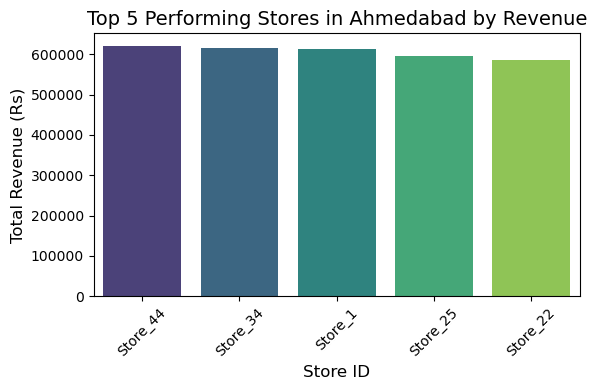

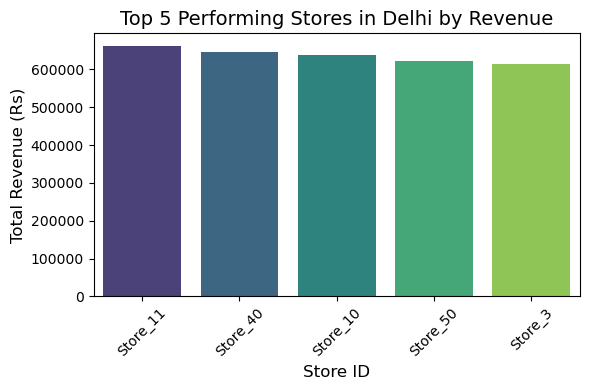

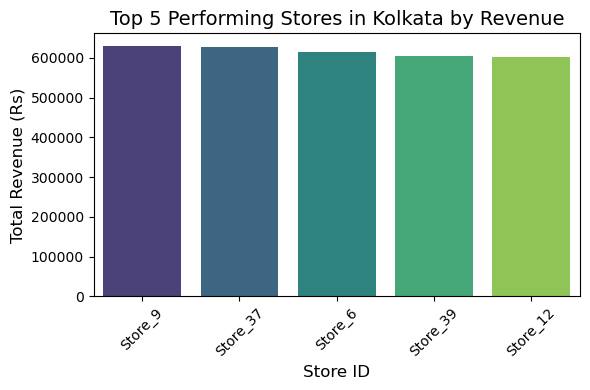

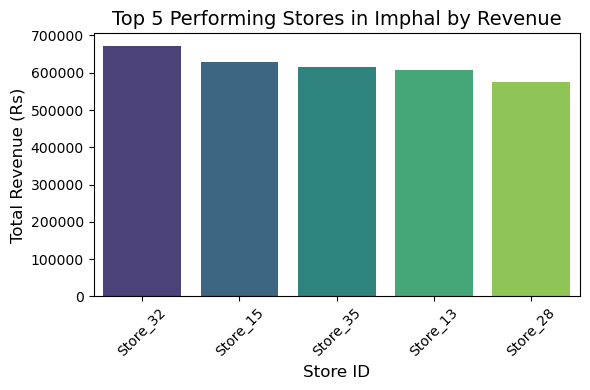

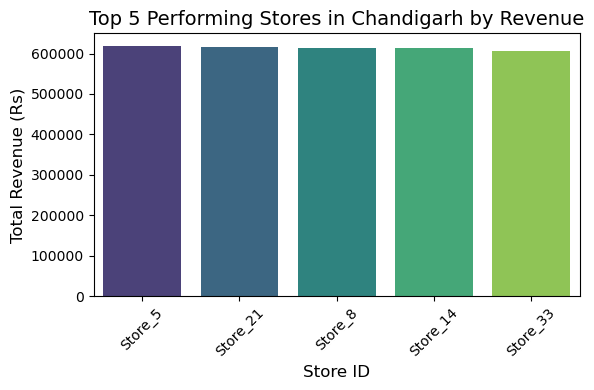

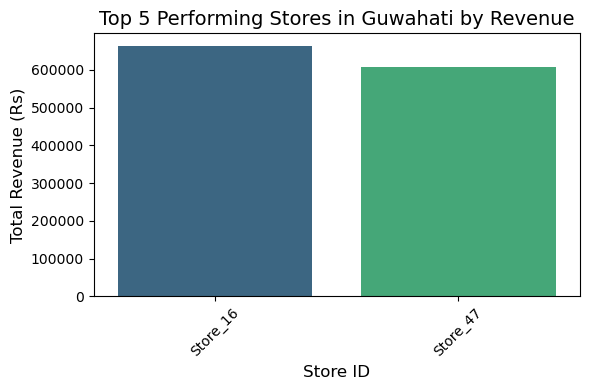

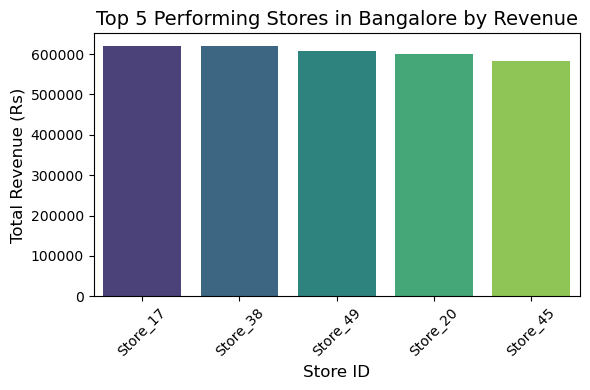

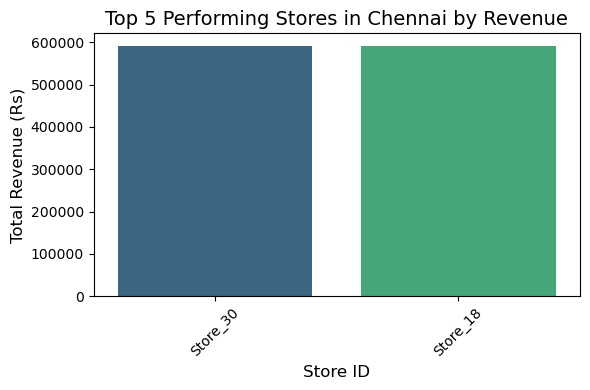

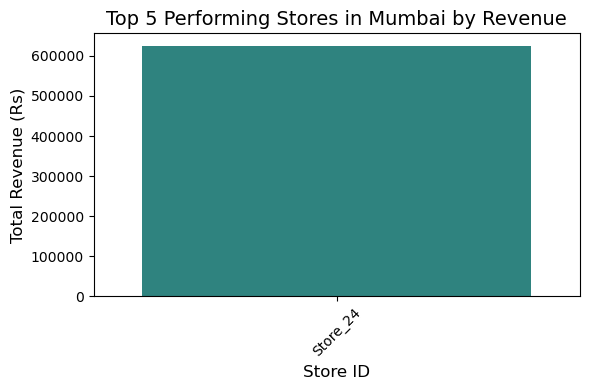

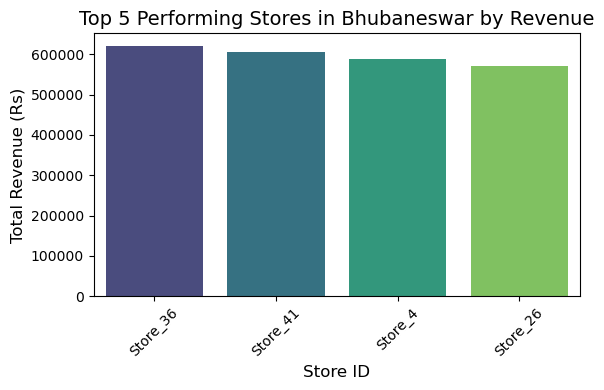

In [16]:
# Step 2: Group by city and filter top-performing stores per city
cities = store_performance['city'].unique()

for city in cities:
    city_performance = store_performance[store_performance['city'] == city]
    
    # Sort and select top 5 stores by revenue
    top_stores_city = city_performance.sort_values(by=["total_spent", "revenue_per_sqft", "footfall_per_sqft"], ascending=False).head(5)

    # Step 3: Visualization for each city
    plt.figure(figsize=(6, 4))
    sns.barplot(data=top_stores_city, x="store_id", y="total_spent", palette="viridis")
    plt.title(f"Top 5 Performing Stores in {city} by Revenue", fontsize=14)
    plt.xlabel("Store ID", fontsize=12)
    plt.ylabel("Total Revenue (Rs)", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [18]:
# 2. New Store Location Recommendations
city_performance = transactions.groupby("city")["total_spent"].sum().reset_index()
city_footfall = stores.groupby("city")["monthly_footfall"].sum().reset_index()

# Merge revenue and footfall data
city_analysis = city_performance.merge(city_footfall, on="city", how="left")
city_analysis["revenue_per_visitor"] = city_analysis["total_spent"] / city_analysis["monthly_footfall"]

city_analysis.head()

,city,total_spent,monthly_footfall,revenue_per_visitor
0,Ahmedabad,2932006.94,55394.0,52.930045
1,Bangalore,3158420.38,73858.0,42.763416
2,Bhubaneswar,2930673.78,52157.0,56.189462
3,Chandigarh,2980134.21,86899.0,34.294229
4,Chennai,3281033.16,22326.0,146.960188


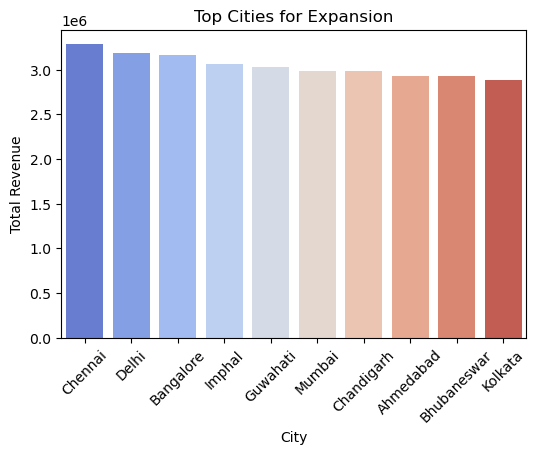

In [21]:
# Identify best cities for expansion
top_cities = city_analysis.sort_values(by=["total_spent", "revenue_per_visitor"], ascending=False)

# Visualization: Best Cities for Expansion
plt.figure(figsize=(6, 4))
sns.barplot(data=top_cities.head(10), x="city", y="total_spent", palette="coolwarm")
plt.title("Top Cities for Expansion")
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.show()

In [33]:
# Step 1: Aggregate total revenue and quantity by product and city
product_sales = transactions.groupby(["store_id", "product_id"])[["total_spent", "quantity"]].sum().reset_index()

# Merge with store info to get city data for each store
product_sales = product_sales.merge(stores[["store_id", "city"]], on="store_id", how="left")

# Merge with products to get product details (e.g., name, category)
product_sales = product_sales.merge(products[["product_id", "subcategory"]], on="product_id", how="left")

# Step 2: Calculate average spent per unit (optional)
product_sales["avg_spent_per_unit"] = product_sales["total_spent"] / product_sales["quantity"]

# Step 3: Filter top 5 products by revenue per city
top_products_by_city = product_sales.groupby('city').apply(lambda x: x.nlargest(5, 'total_spent')).reset_index(drop=True)
top_products_by_city.head(10)


,store_id,product_id,total_spent,quantity,city,subcategory,avg_spent_per_unit
0,Store_1,1017,17365.96,41,Ahmedabad,Edible Oil,423.56
1,Store_25,1080,16431.69,33,Ahmedabad,Chips,497.93
2,Store_22,1072,15917.82,38,Ahmedabad,Butter,418.89
3,Store_34,1139,15271.90,35,Ahmedabad,Frozen Meals,436.34
4,Store_34,1031,14039.19,33,Ahmedabad,Dry Fruits,425.43
5,Store_20,1033,19839.49,41,Bangalore,Dry Fruits,483.89
6,Store_43,1056,16884.75,47,Bangalore,Milk,359.25
7,Store_38,1055,16240.44,38,Bangalore,Organic Spices,427.38
8,Store_45,1021,15344.32,32,Bangalore,Ghee,479.51
9,Store_43,1031,15315.48,36,Bangalore,Dry Fruits,425.43


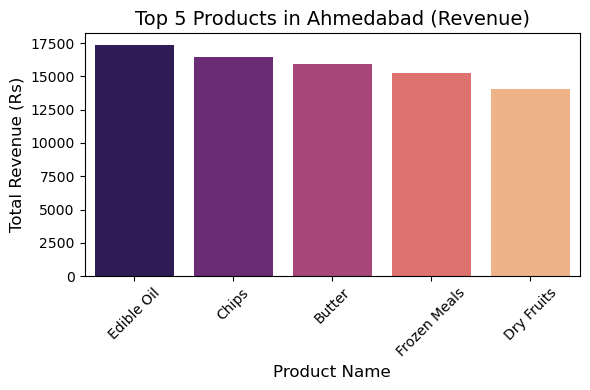

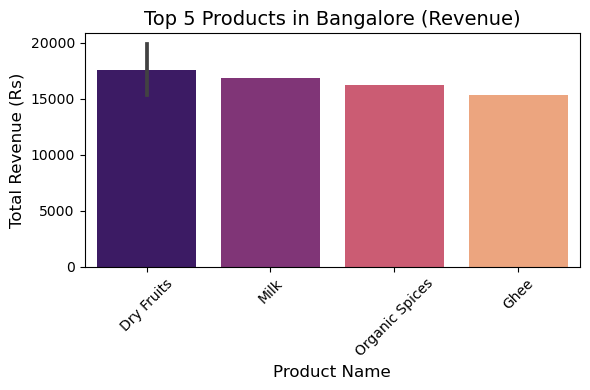

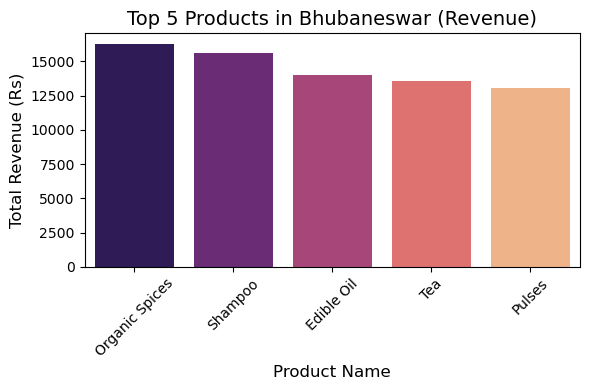

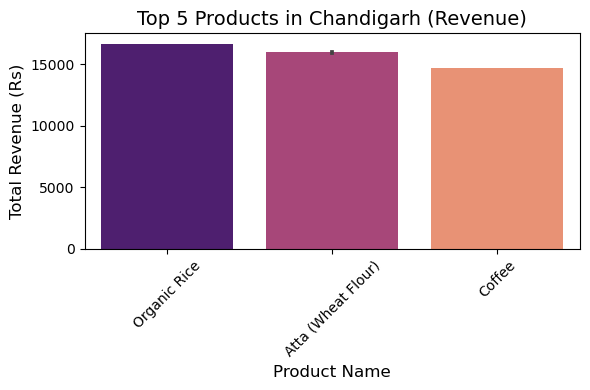

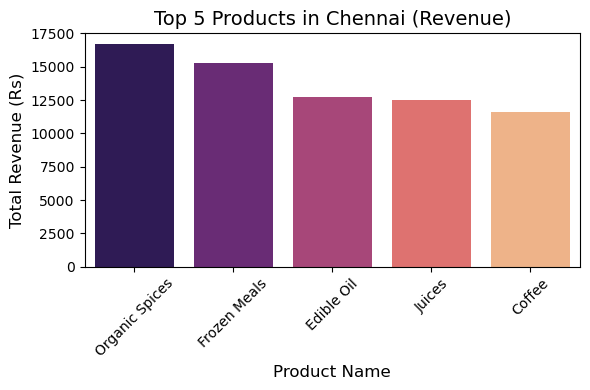

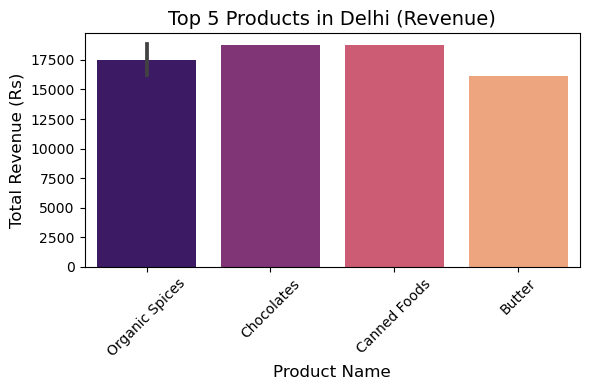

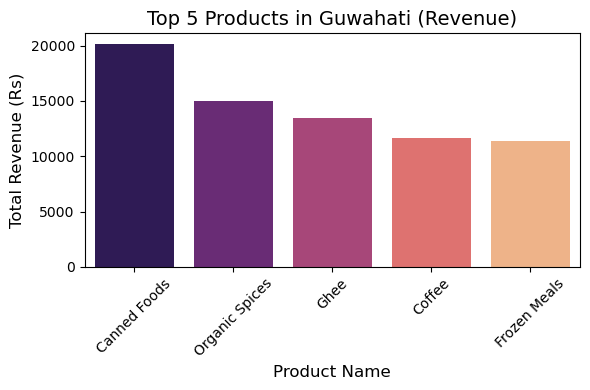

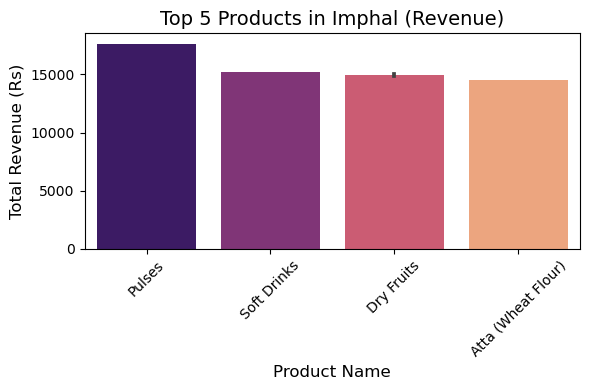

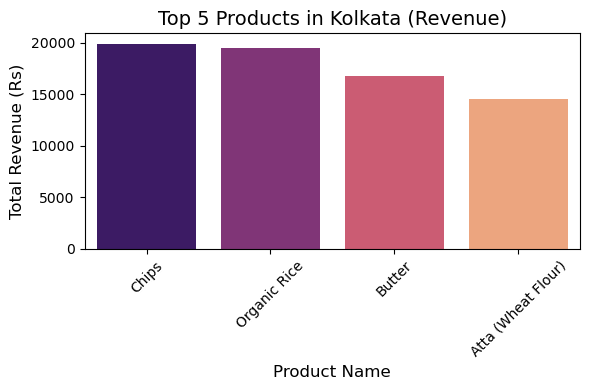

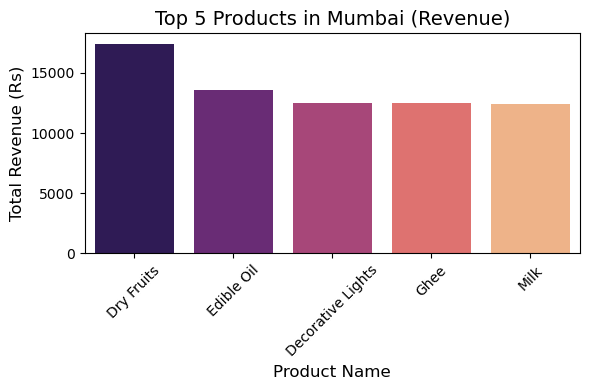

In [22]:
# Step 3: Filter top 5 products by revenue per city
top_products_by_city = product_sales.groupby('city').apply(lambda x: x.nlargest(5, 'total_spent')).reset_index(drop=True)

# Step 4: Create separate graphs for each city with product names
cities = top_products_by_city['city'].unique()

for city in cities:
    city_data = top_products_by_city[top_products_by_city['city'] == city]
    
    plt.figure(figsize=(6, 4))
    sns.barplot(data=city_data, x="subcategory", y="total_spent", palette="magma")
    plt.title(f"Top 5 Products in {city} (Revenue)", fontsize=14)
    plt.xlabel("Product Name", fontsize=12)
    plt.ylabel("Total Revenue (Rs)", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [34]:
# Step 1: Cities with Orders (from transactions) but No Stores (from stores)
city_orders = transactions.groupby("city")["total_spent"].sum().reset_index()

# Get a list of cities that have orders but don't have stores
existing_stores = stores["city"].unique()
cities_with_orders = city_orders[~city_orders["city"].isin(existing_stores)]

# Step 2: Calculate Revenue and Footfall for Cities with Orders but No Stores
city_footfall = stores.groupby("city")["monthly_footfall"].sum().reset_index()

# Merge revenue from transactions with the footfall data
city_analysis = cities_with_orders.merge(city_footfall, on="city", how="left")

# For cities without footfall data (i.e., cities with no stores), we can leave footfall as NaN or estimate it
city_analysis["revenue_per_visitor"] = city_analysis["total_spent"] / city_analysis["monthly_footfall"].fillna(1)

city_analysis.head()


,city,total_spent,monthly_footfall,revenue_per_visitor
0,Gurugram,2183.35,NaN,2183.35
1,Nashik,4912.23,NaN,4912.23
2,Surat,4690.49,NaN,4690.49


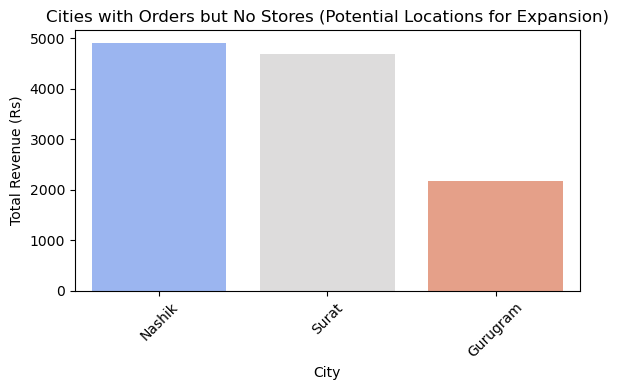

In [35]:
# Step 3: Identify the best cities for new store expansion (based on revenue and footfall)
top_cities_for_expansion = city_analysis.sort_values(by=["total_spent", "revenue_per_visitor"], ascending=False)

# Debugging: Check if the resulting DataFrame is empty
if top_cities_for_expansion.empty:
    print("No cities found for expansion. Check if there are cities with orders but no stores.")
else:
    # Step 4: Visualization - Best Cities for Expansion (Cities with Orders but No Stores)
    plt.figure(figsize=(6, 4))
    sns.barplot(data=top_cities_for_expansion, x="city", y="total_spent", palette="coolwarm")
    plt.title("Cities with Orders but No Stores (Potential Locations for Expansion)")
    plt.xlabel("City")
    plt.ylabel("Total Revenue (Rs)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()